In [42]:
import pandas as pd
import numpy as np
import pickle

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_rows = 9999
pd.options.display.max_columns = 100

def smape(A, F):
    return 100/len(A) * np.sum(np.abs(F - A) / (np.abs(A) + np.abs(F)))

def rmse(A, F):
    return np.sqrt(np.square(F - A).mean())

def show_ts(ts, forecast=None, title="Title", sampling="Samplingrate"):
    ax = ts.plot(label = "Observed", figsize=(10,3))
    if not (forecast is None):
        forecast.plot(ax=ax, label='Forecast')
        plt.legend()

    ax.set_xlabel('Date')
    ax.set_ylabel('Messages/'+sampling)
    plt.title(title)
    plt.show()

In [43]:
# Load data into memory
dataset_names = ["avazu","IoT","wiki_de","wiki_en","horton","retailrocket","taxi","alibaba","google"]
sampling_rates = ["1h","15min","5min"]

datasets = {}  # {dataset_name: {sampling_rate: df}}

for dataset_name in dataset_names:
    datasets[dataset_name] = {}
    for sampling_rate in sampling_rates:
        results_statistical = pd.read_csv(f"results/{dataset_name}_{sampling_rate}_results.csv", index_col=0, parse_dates=True)
        results_ml = pd.read_csv(f"dl_experiments/results/{dataset_name}_{sampling_rate}_cuda:0_results.csv", index_col=0, parse_dates=True)

        df = pd.concat([results_statistical, results_ml[["GRU", "CNN"]]], axis=1)
        df.name = f"{dataset_name}_{sampling_rate}"
        datasets[dataset_name][sampling_rate] = df

In [ ]:
# Print SMAPE
for dataset_name, x in datasets.items():
    print(dataset_name)
    for sampling_rate, df in x.items():
        print("\t"+sampling_rate)
        models = df.columns[1:]
        for model in models:
            print(f"\t\t{model}: {smape(df.t,df[model]):.2f}")
            model_smape[m] = smape(df.t,df[model])

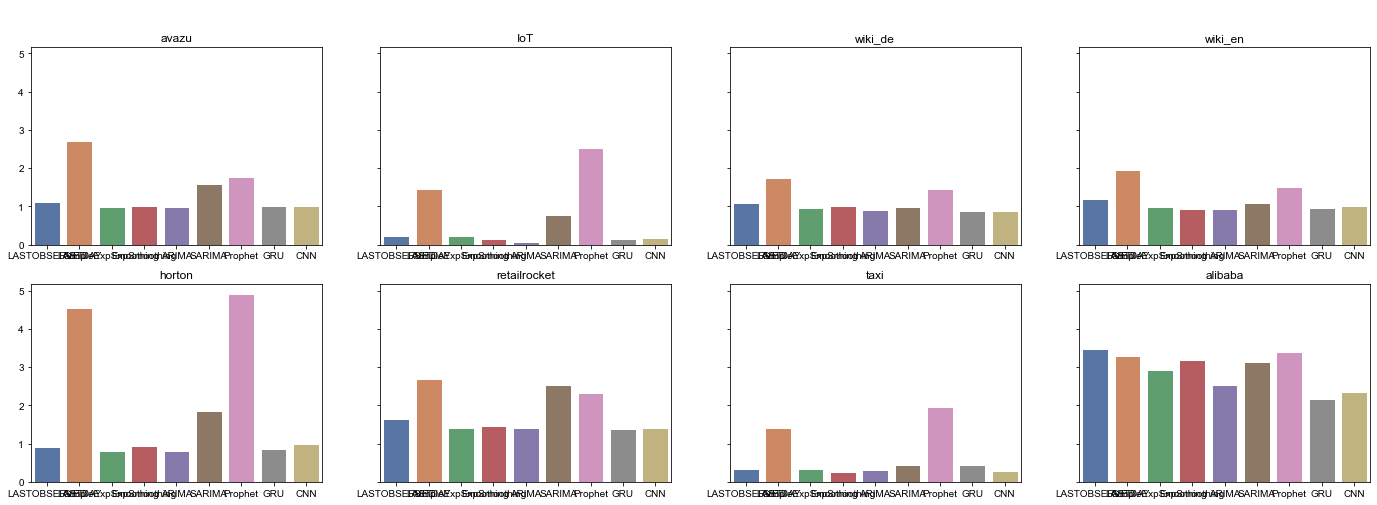

In [44]:
f, axs = plt.subplots(ncols=4, nrows=2, sharey=True, figsize=(24,8))
axs = [ax for axs_col in axs for ax in axs_col]
#f.tight_layout(pad=0)
sns.set_theme(style='ticks')
            
for (dataset_name, x), ax in zip(datasets.items(), axs):
    df = x["5min"]
    
    model_smape = {}
    for model in df.columns[1:]:
        model_smape[model] = smape(df.t,df[model])
    model_smape = pd.DataFrame([model_smape])
    #print(model_smape)
    
    sns.barplot(data=model_smape, ax=ax)
    ax.title.set_text(dataset_name)
    ax.set(xlabel="")
            
    #model_smape.plot(ax=ax)
    
    #ax.title.set_text(dataset_name)
    #ax.set(xlabel="")
    
    #ax.set_xlim(0, 1440 * 7)
    
    #ax.axvline(1440*5, color="k")

    #for idx, _ in x.groupby("time").mean().sort_values(df.name)[:steps].iterrows():
    #    ax.axvspan(idx, idx+30, facecolor="0.5", alpha=0.5, lw=0)
    
    #ticks = range(0, 7*24*60+1, 24*60)
    #ax.set_xticks(ticks)
    #ax.set_xticks(range(0, 7*24*60+1, 6*60), minor=True)
    #ax.set_xticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun", "Mon"])

#ax.set(xlabel="Days of the Week")
#f.text(-0.075, 0.5, "Carbon intensity (gCO2/kWh)", ha="center", va="center", rotation="vertical")
handles, labels = ax.get_legend_handles_labels()
f.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.11, 0.96), frameon=False, ncol=len(labels))


In [ ]:
x = datasets["alibaba"]["1h"]

x.t.plot()
x.SARIMA.plot()
x.Prophet.plot()


In [ ]:
f, axs = plt.subplots(ncols=1, nrows=3, sharex=True, figsize=(7,7))
f.tight_layout(h_pad=0)

palette = sns.color_palette(["#79869f", "#6f83a9", '#701f57', '#ad1759', '#e13342', '#f37651', '#4c72b0', '#4a998f', '#68ae90'])

def results_plot(sampling_rate, ax):
    dfs = []
    for dataset_name, x in datasets.items():
        df = x[sampling_rate]
        model_smape = pd.DataFrame([{model: smape(df.t,df[model]) for model in df.columns[1:]}])
        model_smape["dataset"] = dataset_name
        dfs.append(model_smape)
    
    d = pd.concat(dfs, ignore_index=True)
    d = d.rename(columns={"LASTOBSERVED": "Last\nobserved", "LASTDAY": "Last\nday", "SimpleExpSmoothing": "SES", "ExpSmoothing": "TES"})
    d = pd.melt(d, id_vars=["dataset"], var_name="algorithm", value_name="SMAPE")
    
    if sampling_rate == "5min":
        d.loc[d["algorithm"] == "Prophet", "SMAPE"] = np.nan
        d.loc[d["algorithm"] == "SARIMA", "SMAPE"] = np.nan
        
    if sampling_rate == "15min":
        d.loc[d["algorithm"] == "Prophet", "SMAPE"] = np.nan
    
    means = d.groupby('algorithm').mean()
    min_baseline = min(means.loc["Last\nday"][0], means.loc["Last\nobserved"][0])
    ax.axhline(y=min_baseline, linewidth=1, color=(.5, .5, .5), zorder=0)
    
    g = sns.barplot(data=d, x="algorithm", y="SMAPE", palette=palette, ax=ax)
    ax = g.axes
    ax.set_xlabel('')
    ax.set_ylabel(sampling_rate)
    
    #groupedvalues=df.groupby('day').sum().reset_index()
    
    #plt.legend(title="sampling rate", loc="upper left", framealpha=1)

results_plot("1h", axs[0])
results_plot("15min", axs[1])
results_plot("5min", axs[2])

#f.text(-0.03, 0.5, 'SMAPE', va='center', rotation='vertical')

plt.savefig(f"plots/results_smape.pdf", dpi=300, bbox_inches='tight')

In [ ]:
f, axs = plt.subplots(ncols=1, nrows=3, sharex=True, figsize=(7,7))
f.tight_layout(h_pad=0)

palette = sns.color_palette(["#79869f", "#6f83a9", '#701f57', '#ad1759', '#e13342', '#f37651', '#4c72b0', '#4a998f', '#68ae90'])

def results_plot(sampling_rate, ax):
    dfs = []
    for dataset_name, x in datasets.items():
        df = x[sampling_rate]
        model_smape = pd.DataFrame([{model: smape(df.t,df[model]) for model in df.columns[1:]}])
        model_smape["dataset"] = dataset_name
        model_smape["metric"] = "SMAPE"
        dfs.append(model_smape)
    for dataset_name, x in datasets.items():
        df = x[sampling_rate]
        model_smape = pd.DataFrame([{model: rmse(df.t,df[model]) for model in df.columns[1:]}])
        model_smape["dataset"] = dataset_name
        model_smape["metric"] = "RMSE"
        dfs.append(model_smape)
    
    d = pd.concat(dfs, ignore_index=True)
    d = d.rename(columns={"LASTOBSERVED": "Last\nobserved", "LASTDAY": "Last\nday", "SimpleExpSmoothing": "SES", "ExpSmoothing": "TES"})
    d = pd.melt(d, id_vars=["dataset", "metric"], var_name="algorithm", value_name="error")
    
    if sampling_rate == "5min":
        d.loc[d["algorithm"] == "Prophet", "error"] = np.nan
        d.loc[d["algorithm"] == "SARIMA", "error"] = np.nan
        
    if sampling_rate == "15min":
        d.loc[d["algorithm"] == "Prophet", "error"] = np.nan
    
    means = d.groupby('algorithm').mean()
    min_baseline = min(means.loc["Last\nday"][0], means.loc["Last\nobserved"][0])
    ax.axhline(y=min_baseline, linewidth=1, color=(.5, .5, .5), zorder=0)
    
    g = sns.barplot(data=d, x="algorithm", y="error", hue="metric", palette=palette, ax=ax)
    ax = g.axes
    ax.set_xlabel('')
    ax.set_ylabel(sampling_rate)
    
    #groupedvalues=df.groupby('day').sum().reset_index()
    
    #plt.legend(title="sampling rate", loc="upper left", framealpha=1)

results_plot("1h", axs[0])
results_plot("15min", axs[1])
results_plot("5min", axs[2])

#f.text(-0.03, 0.5, 'SMAPE', va='center', rotation='vertical')

plt.savefig(f"plots/results_rmse.pdf", dpi=300, bbox_inches='tight')

In [ ]:
dfs = []
for dataset_name, x in datasets.items():
    df = x["5min"]
    model_smape = {}
    for model in df.columns[1:]:
        model_smape[model] = rmse(df.t,df[model])
    model_smape = pd.DataFrame([model_smape])
    model_smape["dataset"] = dataset_name
    dfs.append(model_smape)

d = pd.concat(dfs, ignore_index=True)
d = d.rename(columns={"LASTOBSERVED": "Last\nobserved", "LASTDAY": "Last\nday", "SimpleExpSmoothing": "Single\nExp", "ExpSmoothing": "Triple\nExp"})
d = pd.melt(d, id_vars=["dataset"], var_name="algorithm", value_name="SMAPE")

means = d.groupby('algorithm').mean()
min_baseline = min(means.loc["Last\nday"][0], means.loc["Last\nobserved"][0])
ax.axhline(y=min_baseline, linewidth=1, color=(.5, .5, .5), zorder=0)

sns.barplot(data=d, x="dataset", y="SMAPE", palette=palette)

In [45]:
durations = pd.read_csv("results/durations.csv")
# remove invalid Prophet models
durations.loc[durations["sampling_rate"] == "15min", "Prophet"] = np.nan
durations.loc[durations["sampling_rate"] == "5min", "Prophet"] = np.nan
durations.loc[durations["sampling_rate"] == "15min", "Prophet_tune"] = np.nan
durations.loc[durations["sampling_rate"] == "5min", "Prophet_tune"] = np.nan

In [46]:
durations_ml = pd.read_csv("dl_experiments/results/durations.csv").drop(columns=["device"])
durations = pd.merge(durations, durations_ml, on=["dataset", "sampling_rate"])
durations

,dataset,sampling_rate,SARIMA_opt,SARIMA_tune,LASTOBSERVED,ARIMA_opt,ARIMA_tune,SimpleExpSmoothing,SimpleExpSmoothing_tune,ExpSmoothing,ExpSmoothing_tune,Prophet,Prophet_tune,GRU_pred,GRU_train,CNN_pred,CNN_train
0,avazu,1h,304.225096,1.162240,0.001118,1.162102,0.012148,0.005414,0.005989,0.037405,0.018584,0.689940,0.054385,0.000036,260.914510,0.000031,234.710323
1,avazu,15min,1288.256112,25.055953,0.000706,9.580455,0.076839,0.004212,0.007159,0.069858,0.042675,NaN,NaN,0.000032,805.870882,0.000020,596.030427
2,avazu,5min,NaN,NaN,0.000718,39.769271,0.291401,0.006685,0.010411,0.499798,0.130122,NaN,NaN,0.000045,3018.965930,0.000014,2143.257550
3,IoT,1h,235.632510,0.067819,0.000709,4.308953,0.029441,0.004894,0.006423,0.038814,0.021879,0.074572,0.067153,0.000055,622.469252,0.000026,376.477993
4,IoT,15min,2061.989176,8.137557,0.000734,15.696772,0.193426,0.005194,0.008519,0.079805,0.051092,NaN,NaN,0.000076,2202.691900,0.000016,1346.821065
5,IoT,5min,NaN,NaN,0.000753,35.072346,1.146911,0.009254,0.014450,0.619137,0.158560,NaN,NaN,0.000021,4494.434478,0.000014,2737.068969
6,wiki_de,1h,205.504381,0.061815,0.000715,4.625229,0.054853,0.004600,0.006422,0.038386,0.022059,0.124040,0.088371,0.000053,506.212080,0.000046,498.958903
7,wiki_de,15min,2907.406277,4.497017,0.000716,6.867576,0.094000,0.005208,0.008464,0.077690,0.050837,NaN,NaN,0.000053,1813.423469,0.000021,1051.539143
8,wiki_de,5min,NaN,NaN,0.000775,27.670827,0.228568,0.010075,0.014562,0.541803,0.437855,NaN,NaN,0.000030,4293.818986,0.000014,3528.625600
9,wiki_en,1h,310.602459,1.040674,0.000700,2.292106,0.037227,0.004454,0.006915,0.039346,0.022749,0.193899,0.086162,0.000076,598.583777,0.000025,389.644087


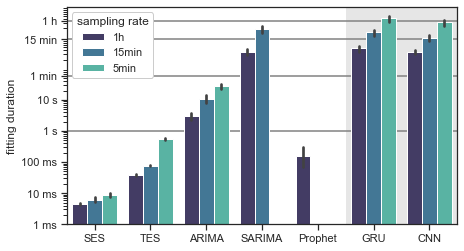

In [47]:
d = durations[["dataset", "sampling_rate", "SimpleExpSmoothing", "ExpSmoothing", "ARIMA_opt", "SARIMA_opt", "Prophet", "GRU_train", "CNN_train"]]
d = d.rename(columns={"SARIMA_opt": "SARIMA", "ARIMA_opt": "ARIMA", "SimpleExpSmoothing": "SES", "ExpSmoothing": "TES", "GRU_train": "GRU", "CNN_train": "CNN"})
d = pd.melt(d, id_vars=["dataset", "sampling_rate"], var_name="algorithm", value_name="duration")

plt.figure(figsize=(7,4))
plt.axvspan(xmin=4.5, xmax=7, color=(.9, .9, .9), zorder=-1)
#plt.axvline(x=4.5, color=(.5, .5, .5), zorder=0)
plt.axhline(y=1, color=(.5, .5, .5), zorder=0)
plt.axhline(y=60, color=(.5, .5, .5), zorder=0)
plt.axhline(y=60*15, color=(.5, .5, .5), zorder=0)
plt.axhline(y=3600, color=(.5, .5, .5), zorder=0)

g = sns.barplot(data=d, x="algorithm", y="duration", hue="sampling_rate", palette="mako")
g.set_yscale("log")
ax = g.axes
ax.set_yticks([0.001, 0.01, 0.1, 1, 10, 60, 60*15, 3600])
ax.set_yticklabels(["1 ms", "10 ms", "100 ms", "1 s", "10 s", "1 min", "15 min", "1 h"])
ax.set_xlabel('')
ax.set_ylabel("fitting duration")
    
plt.legend(title="sampling rate", loc="upper left", framealpha=1)
plt.savefig("plots/train_duration.pdf", dpi=300, bbox_inches='tight')

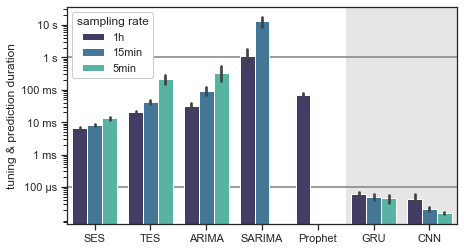

In [48]:
d = durations[["dataset", "sampling_rate", "SimpleExpSmoothing_tune", "ExpSmoothing_tune", "ARIMA_tune", "SARIMA_tune", "Prophet_tune", "GRU_pred", "CNN_pred"]]
d = d.rename(columns={"SARIMA_tune": "SARIMA", "ARIMA_tune": "ARIMA", "SimpleExpSmoothing_tune": "SES", "ExpSmoothing_tune": "TES", "Prophet_tune": "Prophet", "GRU_pred": "GRU", "CNN_pred": "CNN"})
d = pd.melt(d, id_vars=["dataset", "sampling_rate"], var_name="algorithm", value_name="duration")

plt.figure(figsize=(7,4))
plt.axvspan(xmin=4.5, xmax=7, color=(.9, .9, .9), zorder=-1)
#plt.axvline(x=4.5, color=(.5, .5, .5), zorder=0)
plt.axhline(y=1, color=(.5, .5, .5), zorder=0)
plt.axhline(y=0.0001, color=(.5, .5, .5), zorder=0)

g = sns.barplot(data=d, x="algorithm", y="duration", hue="sampling_rate", palette="mako")
g.set_yscale("log")
ax = g.axes
ax.set_yticks([0.0001, 0.001, 0.01, 0.1, 1, 10])
ax.set_yticklabels(["100 µs", "1 ms", "10 ms", "100 ms", "1 s", "10 s"])
ax.set_xlabel('')
ax.set_ylabel("tuning & prediction duration")
    
plt.legend(title="sampling rate", loc="upper left", framealpha=1)
plt.savefig("plots/pred_duration.pdf", dpi=300, bbox_inches='tight')

In [ ]:

pd.read_csv("results/google_1h_results.csv", index_col=0, parse_dates=True).drop(columns=["LASTOBSERVED", "LASTDAY"]).plot(figsize=(15,5))

In [ ]:
palette = sns.color_palette(["#000", '#701f57', '#e13342', '#f37651', '#4c72b0', '#4a998f', '#68ae90'])


for dataset_name, x in datasets.items():
    df = x["1h"]
    df = df.drop(columns=["LASTOBSERVED", "LASTDAY", "SimpleExpSmoothing"])
    plt.figure(figsize=(7,4))
    sns.lineplot(data=df, dashes=False, palette=palette)
    ax = plt.gca()
    ax.set(xlabel=dataset_name)

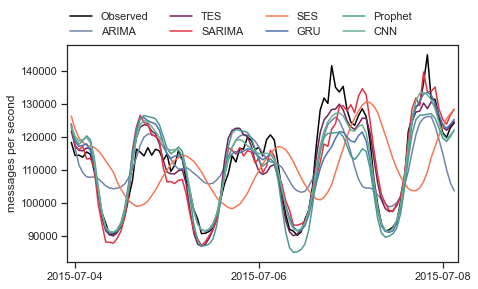

In [71]:
palette = sns.color_palette(["#000", "#6f83a9", '#701f57', '#e13342', '#f37651', '#4c72b0', '#4a998f', '#68ae90'])

df = datasets["retailrocket"]["1h"]
df = df.drop(columns=["LASTOBSERVED", "LASTDAY"])
df = df.rename(columns={"t": "Observed", "SimpleExpSmoothing": "SES", "ExpSmoothing": "TES", "GRU_train": "GRU", "CNN_train": "CNN"})
df = df[["Observed", "ARIMA", "TES", "SARIMA", "SES", "GRU", "Prophet", "CNN"]]
f = plt.figure(figsize=(7,4))
sns.lineplot(data=df, dashes=False, palette=palette)
ax = plt.gca()
ax.set(ylabel="messages per second")
ax.set(xlabel="")
ax.get_legend().remove()
f.legend(loc='upper left', bbox_to_anchor=(0.11, 1.03), frameon=False, ncol=4)

from datetime import timedelta

# Ticks are a little hacky right now
start = df.index[0]
xticks = []
xticklabels = []
for days in range(0, 6, 2):
    t = start + timedelta(days=days, hours=1)
    xticks.append(t)
    xticklabels.append(t.strftime("%Y-%m-%d"))
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.margins(x=0.01)
    
plt.savefig("plots/prediction_retailrocket.pdf", dpi=300, bbox_inches='tight')

In [ ]:
palette = sns.color_palette(["#000", '#701f57', '#e13342', '#f37651']) # , '#4c72b0', '#4a998f', '#68ae90'])

df = datasets["google"]["1h"]
df = df[["t", "ExpSmoothing", "ARIMA", "SARIMA"]]
plt.figure(figsize=(7,4))
sns.lineplot(data=df, dashes=False, palette=palette)
ax = plt.gca()
ax.set(xlabel=dataset_name)

In [ ]:
sns.color_palette(["#79869f", "#6f83a9", '#701f57', '#ad1759', '#e13342', '#f37651', '#4c72b0', '#4a998f', '#68ae90'])

palette = sns.color_palette(['#701f57', '#ad1759', '#e13342', '#f37651', '#4c72b0', '#4a998f', '#68ae90', "#000"])

df = datasets["wiki_de"]["1h"]
df = df[["SimpleExpSmoothing", "ExpSmoothing", "ARIMA", "SARIMA", "Prophet", "GRU", "CNN", "t"]]
df = df["2019-07-17 19:00:00":"2019-07-18 19:00:00"]
plt.figure(figsize=(7,4))
sns.lineplot(data=df, dashes=False, palette=palette)
ax = plt.gca()
ax.set(xlabel="wiki_de")

In [ ]:
df

In [ ]:
df = datasets["horton"]["1h"]
df = df[["t", "LASTOBSERVED", "ARIMA", "CNN"]]
plt.figure(figsize=(7,4))
sns.lineplot(data=df, dashes=False, palette=palette)
ax = plt.gca()
ax.set(xlabel="horton")

In [ ]:
sns.color_palette(["#79869f", "#6f83a9", '#701f57', '#ad1759', '#e13342', '#f37651', '#4c72b0', '#4a998f', '#68ae90'])

palette = sns.color_palette(["#000", '#e13342', '#68ae90'])

df = datasets["wiki_de"]["15min"]
df = df[["t", "ARIMA", "CNN"]]
df = df['2019-07-18 00:00:00':'2019-07-19 00:00:00']
plt.figure(figsize=(7,4))
sns.lineplot(data=df, dashes=False, palette=palette)
ax = plt.gca()
ax.set(xlabel="wiki_de")

In [ ]:

df.index

In [ ]:
datasets["wiki_de"]["15min"]

In [ ]:
dfs = []

for dataset_name, x in datasets.items():
    sampling_rate_dfs = []
    for sampling_rate, df in x.items():
        s = pd.DataFrame([{model: smape(df.t,df[model]) for model in df.columns[1:]}])
        sampling_rate_dfs.append(s)
    df = pd.concat(sampling_rate_dfs)
    df.index = pd.Index(sampling_rates, name="sampling rate")
    df["dataset"] = dataset_name
    df.set_index("dataset", append=True, inplace=True)
    dfs.append(df)
df = pd.concat(dfs)
df = df.reorder_levels(['sampling rate', 'dataset']).sort_index()
df.columns = pd.Index(['Last observation', 'Last day', 'SES', 'TES', 'ARIMA', 'SARIMA', 'Prophet', 'GRU', 'CNN'])

#print(df.to_latex(float_format='%.2f'))

df